In this notebook, we'll look at a few ways that the [CReM](https://github.com/DrrDom/crem) (**C**hemicall **Re**asonable **M**olecules) Python library can be used to to expand a fragment molecule.  For this example, we'll use one of the fragments (x0161) from the COVID-19 fragment screen run at the [Diamond Light Source](https://www.diamond.ac.uk/covid-19/for-scientists/Main-protease-structure-and-XChem.html).  

Load the necessary Python libraries

In [1]:
from rdkit import Chem
from crem.crem import grow_mol
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage
from reos import REOS
import random
from rdkit.Chem.rdmolops import RemoveHs
import pandas as pd

RDKit WARNING: [13:38:31] Enabling RDKit 2019.09.3 jupyter extensions


Define the SMILES for our fragment (x0161 from the Diamond/XChem set)

In [2]:
frag_smi = "COC(=O)C=1C=CC(=CC1)S(=O)(=O)N"
frag_mol = Chem.MolFromSmiles(frag_smi)

Define 2D coordinates for the molecule and display it

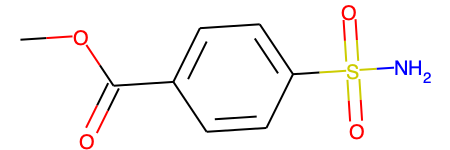

In [3]:
AllChem.Compute2DCoords(frag_mol)
frag_mol

Specify the CReM database file

In [4]:
crem_db_file = '/Users/pwalters/modsource/python/rdkit/crem/replacements_sc2.5.db'

Use the most general form of the grow_mol function.  We will add fragments with up to 9 atoms to every open valence on the molecule. Because we have specified return_mol=True, the return value is a tuple (smiles, mol) where smiles is the generated SMILES and mol is the corresponding RDKit molecule. We then generate a depiction of each molecule aligned to our original molecule. 

In [5]:
grow_list = list(grow_mol(frag_mol, db_name=crem_db_file,max_atoms=8,return_mol=True))
mol_list = [RemoveHs(x[1]) for x in grow_list]
_ = [AllChem.GenerateDepictionMatching2DStructure(m,frag_mol) for m in mol_list]
print(len(mol_list))

832


Some of the molecules in this set contain functionality that we don't want.  We'll use our REOS class to filter out the molecules that match a a set of SMARTS patterns that specify undesirable functionality.  First we define a REOS object with an input file defining the SMARTS patters. 

In [6]:
reos = REOS("bms_filters.csv")

We can then use the list comprehension below to filter the generated molecules.  774 of 832 molecules pass our REOS filters. 

In [7]:
mol_list = [x for x in mol_list if reos.eval_mol(x)]
print(len(mol_list))

744


Let's look at sample of the genreated molecules.  We'll shuffle the list and take a sample of the first 25 molecules. Looks like we should add another filter for long alkyl chains. 

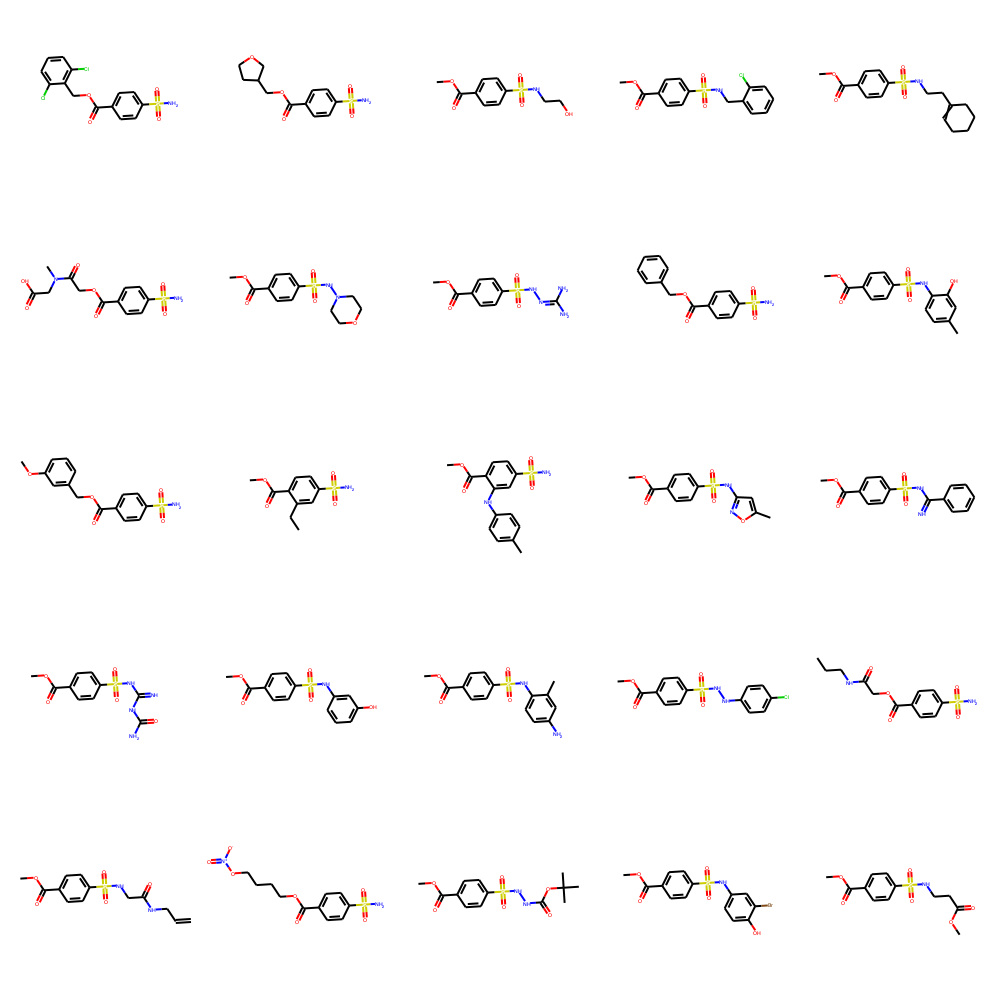

In [8]:
random.shuffle(mol_list)
MolsToGridImage(mol_list[:25],molsPerRow=5)

Save our generated molecules to disk

In [9]:
df = pd.DataFrame([x[0] for x in grow_list],columns=["SMILES"])
df['Name'] = [f"MOL{x:04d}" for x in range(1,df.shape[0]+1)]
df.to_csv("x0161_set_1.csv",index=False)

In some cases, we may not want to modify part of the molecules.  For instance, let's assume that the sulfonamine NH2 in the fragment is making a hydrogen bond and we don't want to substitute that part of the molecule.  The grow_mol function allows us to specify the atom numbers for the atoms that should not be substituted.  In order to make this easier to use, we'll define a fucntion to return atom numbers matching a SMARTs pattern. 

In [10]:
def get_matching_atoms(mol_in,smarts):
    pat = Chem.MolFromSmarts(smarts)
    return [x[0] for x in mol_in.GetSubstructMatches(pat)]

We can now use this function to get the atom number for the sulfonamide nitrogen.

In [11]:
sulfonamide_N = get_matching_atoms(frag_mol,"[NH2]")

This time we'll add substituents to the molecule, but avoid the sulfonamide nitrogen. 

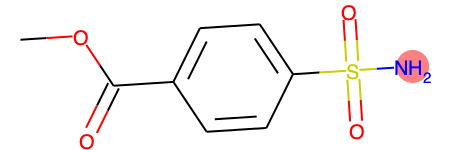

In [12]:
frag_mol

In [13]:
grow_list = list(grow_mol(frag_mol, db_name=crem_db_file,max_atoms=8,protected_ids=sulfonamide_N,return_mol=True))
mol_list = [x for x in mol_list if reos.eval_mol(x)]
mol_list = [RemoveHs(x[1]) for x in grow_list]
_ = [AllChem.GenerateDepictionMatching2DStructure(m,frag_mol) for m in mol_list]

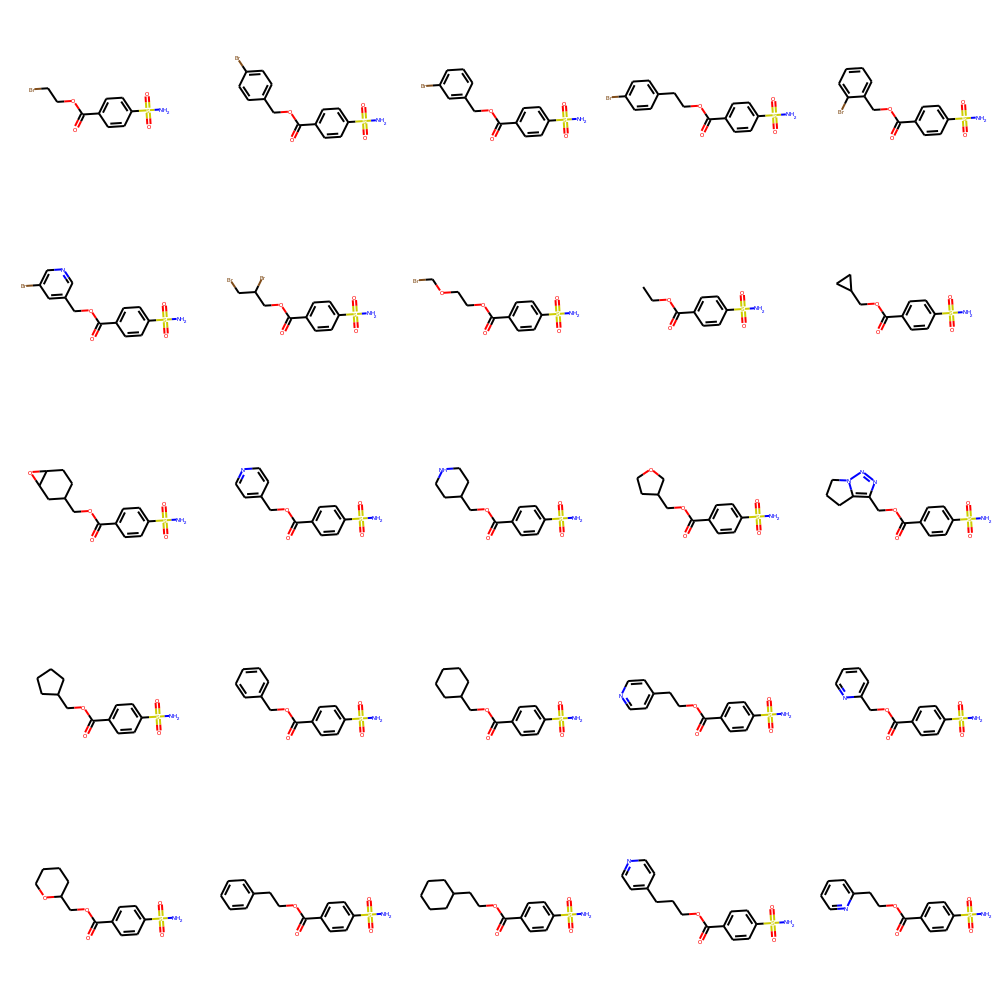

In [14]:
MolsToGridImage(mol_list[:25],molsPerRow=5)

Save our generated molecules to disk.

In [15]:
df = pd.DataFrame([x[0] for x in grow_list],columns=["SMILES"])
df['Name'] = [f"MOL{x:04d}" for x in range(1,df.shape[0]+1)]
df.to_csv("x0161_set_2.csv",index=False)

In a similar fashion, we can specify that **only** certain atoms should to be substituted. In this example, we'll only substitute the aromatic carbons.  We can use the function defined above to select the atoms that will be substituted. 

In [16]:
aromatic_atoms = get_matching_atoms(frag_mol,"[cH]")
aromatic_atoms

[5, 6, 8, 9]

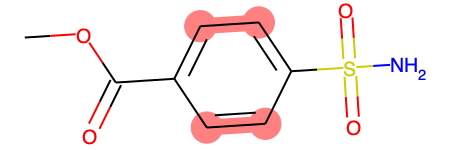

In [17]:
frag_mol

This time we'll call grow_mol with the replace_ids argment to specify which atoms should be substituted. 

In [18]:
grow_list = list(grow_mol(frag_mol, db_name=crem_db_file,max_atoms=5,replace_ids=aromatic_atoms,return_mol=True))
mol_list = [x for x in mol_list if reos.eval_mol(x)]
mol_list = [RemoveHs(x[1]) for x in grow_list]
_ = [AllChem.GenerateDepictionMatching2DStructure(m,frag_mol) for m in mol_list]

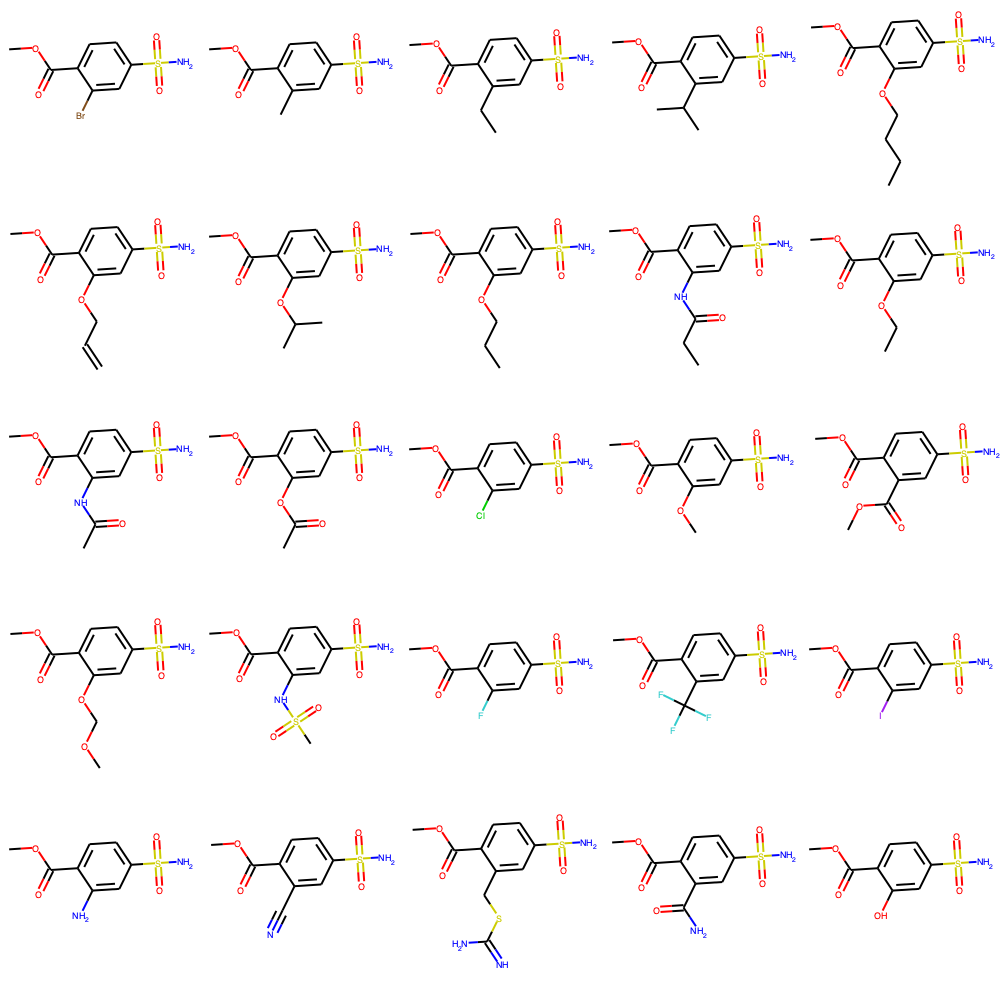

In [19]:
MolsToGridImage(mol_list[:25],molsPerRow=5)

Save our generated molecules to disk

In [20]:
df = pd.DataFrame([x[0] for x in grow_list],columns=["SMILES"])
df['Name'] = [f"MOL{x:04d}" for x in range(1,df.shape[0]+1)]
df.to_csv("x0161_set_3.csv",index=False)